# Step 1: Data Preprocessing

## 1.1 Load and Clean Data

In [34]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Download necessary NLTK resources (stopwords and tokenizer)
nltk.download('stopwords')
nltk.download('punkt')

# Load the dataset from the CSV file (tweets.csv)
# The 'latin-1' encoding is used to handle potential special characters if 'utf-8' causes errors
df = pd.read_csv("tweets.csv", encoding='latin-1')

# We only need the 'target' and 'text' columns for sentiment analysis, so filter the dataframe to keep them
df = df[['target', 'text']]

# Filter the data to keep only rows where 'target' is 0 or 4 (0 = negative, 4 = positive sentiment)
df = df[df['target'].isin([0, 4])]

# Convert 'target' labels: map positive sentiment (4) to 1 (binary classification: 0 = negative, 1 = positive)
df['target'] = df['target'].replace({4: 1})  # 0=negative, 1=positive

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\abhis\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\abhis\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## 1.2 Text Cleaning

In [35]:
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk

# Download the required NLTK resources (tokenizer and stopwords)
nltk.download('punkt')  # Tokenizer
nltk.download('punkt_tab')  # Not necessary (likely a typo in the list)
nltk.download('stopwords')  # List of stopwords for filtering

# Define a function to clean the text data
def clean_text(text):
    text = text.lower()  # Convert the text to lowercase for uniformity
    text = re.sub(r'http\S+', '', text)  # Remove any URLs from the text
    text = re.sub(r'@\w+', '', text)  # Remove Twitter mentions (e.g., @username)
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove any special characters and numbers, keeping only letters and spaces
    tokens = word_tokenize(text)  # Tokenize the cleaned text into individual words
    stop_words = set(stopwords.words('english'))  # Create a set of common stopwords (like "the", "is", etc.)
    tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords from the tokenized text
    return ' '.join(tokens)  # Join the remaining words back into a string

# Apply the cleaning function to the 'text' column of the dataframe and create a new column 'cleaned_text'
df['cleaned_text'] = df['text'].apply(clean_text)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\abhis\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\abhis\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\abhis\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Step 2: Train-Test Split

In [36]:
from sklearn.model_selection import train_test_split

# Assign the cleaned text data as features (X) and the target sentiment labels as the target variable (y)
X = df['cleaned_text']  # Features: the cleaned tweet text
y = df['target']  # Labels: the target sentiment (0 = negative, 1 = positive)

# Split the dataset into training and testing sets
# test_size=0.2 means 20% of the data will be used for testing, and 80% for training
# random_state=42 ensures the split is reproducible
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: LSTM with GloVe Embedding

## 3.1 Tokenization & Padding

In [10]:
!pip install tensorflow

   ---------------------------------------- 0.0/390.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/390.3 MB ? eta -:--:--
   ---------------------------------------- 0.5/390.3 MB 3.4 MB/s eta 0:01:56
   ---------------------------------------- 1.0/390.3 MB 2.1 MB/s eta 0:03:06
   ---------------------------------------- 1.3/390.3 MB 2.0 MB/s eta 0:03:12
   ---------------------------------------- 1.8/390.3 MB 2.1 MB/s eta 0:03:09
   ---------------------------------------- 2.1/390.3 MB 2.1 MB/s eta 0:03:09
   ---------------------------------------- 2.6/390.3 MB 2.1 MB/s eta 0:03:03
   ---------------------------------------- 3.4/390.3 MB 2.2 MB/s eta 0:02:53
   ---------------------------------------- 4.5/390.3 MB 2.5 MB/s eta 0:02:33
    --------------------------------------- 5.2/390.3 MB 2.7 MB/s eta 0:02:22
    --------------------------------------- 6.3/390.3 MB 2.9 MB/s eta 0:02:13
    --------------------------------------- 6.8/390.3 MB 3.0 MB/s eta 0:02:09


In [37]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Initialize the tokenizer with a limit of 10,000 unique words and a token for out-of-vocabulary words
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')

# Fit the tokenizer on the training data (learns the word-to-index mappings from the training data)
tokenizer.fit_on_texts(X_train)

# Convert the training and testing text data into sequences of integers (words are replaced by their corresponding index)
train_sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_test)

# Pad the sequences so that they all have the same length (padding/truncating at the end to match the specified max_length)
# max_length is set to 100, but it can be adjusted based on the length of the data
X_train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post', truncating='post')
X_test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post', truncating='post')

## 3.2 Load GloVe Embeddings

In [38]:
# Initialize an empty dictionary to store GloVe embeddings for each word
embeddings_index = {}

# Open the GloVe file (6B tokens, 100-dimensional vectors) and load the word vectors
with open('glove.6B.100d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()  # Split each line into the word and its vector components
        word = values[0]  # The first entry is the word
        coefs = np.asarray(values[1:], dtype='float32')  # The rest are the embedding coefficients (vector)
        embeddings_index[word] = coefs  # Add the word and its vector to the dictionary

# Define the embedding dimension as 100 (since we are using GloVe with 100d vectors)
embedding_dim = 100

# Get the vocabulary size based on the tokenizer's word index (adding 1 for padding token)
vocab_size = len(tokenizer.word_index) + 1

# Initialize the embedding matrix as a zero matrix of shape (vocab_size, embedding_dim)
embedding_matrix = np.zeros((vocab_size, embedding_dim))

# Populate the embedding matrix with GloVe vectors for the words in the tokenizer's word index
for word, i in tokenizer.word_index.items():
    if i < vocab_size:  # Ensure the index is within the vocabulary size limit
        embedding_vector = embeddings_index.get(word)  # Retrieve the GloVe vector for the word
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector  # Assign the GloVe vector to the corresponding index in the matrix

## 3.3 Build LSTM Model

In [39]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

# Define a Sequential model (a stack of layers)
model = Sequential([

    # Add the Embedding layer with GloVe weights
    # input_dim is vocab_size (size of tokenizer vocabulary), output_dim is embedding_dim (100 for GloVe)
    # The weights argument initializes the layer with pre-trained GloVe embeddings
    # input_length specifies the length of input sequences (padded to max_length)
    # trainable=False ensures the GloVe embeddings remain frozen (not updated during training)
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, 
              weights=[embedding_matrix], input_length=max_length, 
              trainable=False),  # Freeze GloVe embeddings
    
    # Add the first LSTM layer with 128 units
    # return_sequences=True allows the layer to output the full sequence of hidden states for the next LSTM layer
    # dropout=0.2 randomly sets 20% of the neurons to 0 during training to prevent overfitting
    LSTM(128, return_sequences=True, dropout=0.2),
    
    # Add a second LSTM layer with 64 units (this is the last LSTM, so no return_sequences)
    LSTM(64),
    
    # Add a fully connected Dense layer with a single neuron and sigmoid activation
    # This outputs the final prediction for binary classification (0 or 1, negative or positive sentiment)
    Dense(1, activation='sigmoid')
])

# Compile the model
# Optimizer: 'adam' (adaptive learning rate optimization algorithm)
# Loss function: binary_crossentropy (for binary classification)
# Metrics: accuracy (to monitor the percentage of correctly classified samples during training)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Output the model summary, which gives a layer-by-layer breakdown of the model architecture
model.summary()

C:\Users\abhis\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ ?                           │       5,485,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,485,300 (20.92 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 5,485,300 (20.92 MB)

## 3.4 Train & Evaluate

In [40]:
# Train the model
# X_train_padded: Padded sequences of training data
# y_train: Corresponding labels for the training data
# epochs=10: Train the model for 10 epochs (iterations over the entire dataset)
# batch_size=64: Process 64 samples at a time during training
# validation_split=0.2: Use 20% of the training data for validation (to monitor model performance on unseen data)
history = model.fit(
    X_train_padded, y_train,
    epochs=10,
    batch_size=64,
    validation_split=0.2
)

# Evaluate the model on test data
# X_test_padded: Padded sequences of test data
# y_test: Corresponding labels for the test data
# This returns the loss and accuracy of the model on test data
loss, accuracy = model.evaluate(X_test_padded, y_test)

# Print the test accuracy in a readable format
print(f"LSTM Test Accuracy: {accuracy * 100:.2f}%")

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 136s 132ms/step - accuracy: 0.5030 - loss: 0.6933 - val_accuracy: 0.5044 - val_loss: 0.6931
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 133s 133ms/step - accuracy: 0.4972 - loss: 0.6932 - val_accuracy: 0.4956 - val_loss: 0.6934
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 140s 131ms/step - accuracy: 0.5010 - loss: 0.6932 - val_accuracy: 0.4956 - val_loss: 0.6932
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 133s 133ms/step - accuracy: 0.4984 - loss: 0.6932 - val_accuracy: 0.4956 - val_loss: 0.6933
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 125s 125ms/step - accuracy: 0.4983 - loss: 0.6932 - val_accuracy: 0.4956 - val_loss: 0.6932
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 142s 142ms/step - accuracy: 0.5030 - loss: 0.6931 - val_accuracy: 0.4956 - val_loss: 0.6932
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 149s 149ms/step - accuracy: 0.5012 - loss: 0.6932 - val_accuracy: 0.4956 - val_loss: 0.6932
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 127s 127ms/step - ac

# Step 4: Multinomial Naive Bayes

## 4.1 TF-IDF Vectorization

In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

# Create a TF-IDF vectorizer with a max feature limit
# max_features=10000: Limit the vocabulary to the top 10,000 most frequent words
# TfidfVectorizer(): This transforms the text data into a matrix of TF-IDF features. 
# The max_features=10000 limits the vocabulary size to 10,000 words, which is useful for handling large datasets efficiently.
tfidf = TfidfVectorizer(max_features=10000)

# Fit the vectorizer on the training data and transform the text into TF-IDF vectors
# fit_transform(): This function both fits the vectorizer on the training data (i.e., learns the vocabulary) and then transforms the text into TF-IDF features.
X_train_tfidf = tfidf.fit_transform(X_train)

# Transform the test data using the fitted vectorizer (don't refit on test data)
# transform(): For the test data, we use the transform() method so that the test data uses the same vocabulary learned from the training data.
X_test_tfidf = tfidf.transform(X_test)

## 4.2 Train & Evaluate

In [42]:
# Train the Naive Bayes classifier
nb = MultinomialNB()
nb.fit(X_train_tfidf, y_train)  # Fit the classifier to the training data

# Make predictions on the test data
y_pred = nb.predict(X_test_tfidf)  # Predict using the fitted model on the test data

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)  # Compare predictions to actual labels
print(f"Naive Bayes Test Accuracy: {accuracy * 100:.2f}%")  # Display test accuracy as a percentage

Naive Bayes Test Accuracy: 76.35%


# Step 5: Comparison & Visualization

## 5.1 Plot Accuracy/Loss Curves (LSTM)

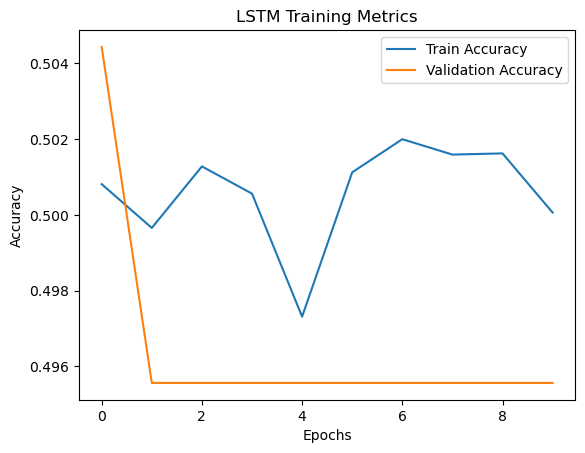

In [43]:
import matplotlib.pyplot as plt

# Plot training accuracy over epochs
plt.plot(history.history['accuracy'], label='Train Accuracy')

# Plot validation accuracy over epochs
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

# Add a title to the plot
plt.title('LSTM Training Metrics')

# Label the x-axis as 'Epochs'
plt.xlabel('Epochs')

# Label the y-axis as 'Accuracy'
plt.ylabel('Accuracy')

# Add a legend to distinguish between train and validation accuracy
plt.legend()

# Display the plot
plt.show()

## 5.2 Confusion Matrix for Both Models

626/626 ━━━━━━━━━━━━━━━━━━━━ 22s 29ms/step


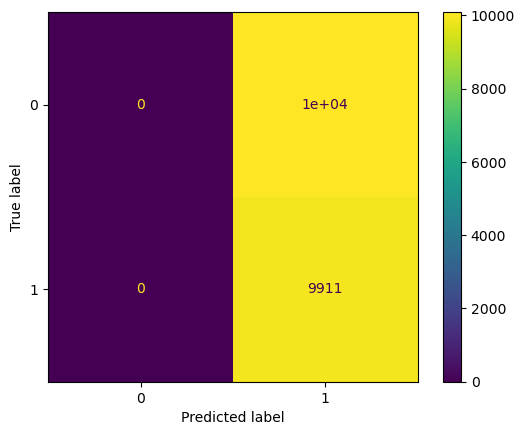

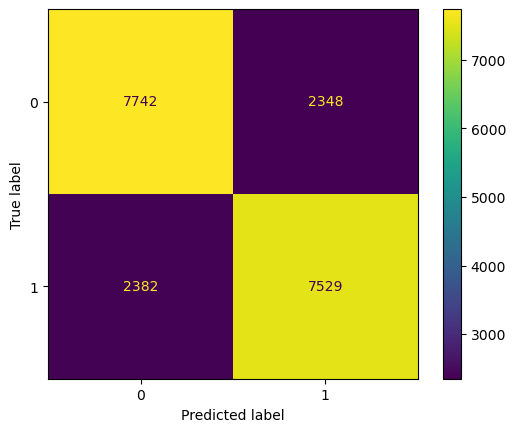

In [44]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# For LSTM
# Predict on the test set using the LSTM model and convert probabilities to binary labels
y_pred_lstm = (model.predict(X_test_padded) > 0.5).astype(int)

# Compute the confusion matrix for the LSTM model
cm_lstm = confusion_matrix(y_test, y_pred_lstm)

# Display the confusion matrix for the LSTM model
ConfusionMatrixDisplay(cm_lstm).plot()

# For Naive Bayes
# Compute the confusion matrix for the Naive Bayes model
cm_nb = confusion_matrix(y_test, y_pred)

# Display the confusion matrix for the Naive Bayes model
ConfusionMatrixDisplay(cm_nb).plot()

# Enhancing the accuracy for LSTM
### Embedding Layer: Set trainable=True to allow fine-tuning of the GloVe embeddings.
### Bidirectional LSTM: Added Bidirectional(LSTM) for better sequence modeling.
### GlobalMaxPooling: Used GlobalMaxPooling1D after the LSTM layers to reduce complexity while preserving important features.
### Dropout Regularization: Increased dropout to 0.3 in the LSTM layer and added a 0.5 dropout before the output layer to prevent overfitting.
### Class Weights: Applied class weights to handle potential class imbalance in the dataset.
### Early Stopping: Integrated EarlyStopping to halt training when validation loss stops improving.
### F1 Score: Evaluated the model using F1-score for a better measure of performance on imbalanced datasets.

In [54]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, GlobalMaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils import class_weight
from sklearn.metrics import f1_score

# Tokenization and Padding
# Initialize the tokenizer, which will convert words into numerical sequences
# The 'oov_token' ensures that any words not present in the training data are handled as 'Out-Of-Vocabulary' (<OOV>).
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)  # Fit the tokenizer only on the training data

# Convert text data into sequences of integers based on the tokenizer's vocabulary
train_sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_test)

# Pad the sequences so that they are all of the same length (max_length)
# Post-padding and post-truncating mean that if sequences are shorter, they are padded at the end, 
# and if they are longer, the extra values are truncated from the end.
max_length = 100  # Define the maximum length of sequences
X_train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post', truncating='post')
X_test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post', truncating='post')

# GloVe Embeddings
# Load the pre-trained GloVe embeddings (100-dimensional vectors for each word)
# We create a dictionary where the key is the word and the value is its embedding vector
embeddings_index = {}
with open('glove.6B.100d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()  # Split each line into word and coefficients
        word = values[0]  # The first value is the word
        coefs = np.asarray(values[1:], dtype='float32')  # The rest are the word's embedding vector
        embeddings_index[word] = coefs  # Store word and its corresponding vector in the dictionary

# Create the embedding matrix where each row corresponds to a word in the tokenizer's vocabulary
embedding_dim = 100  # GloVe embeddings are 100-dimensional
vocab_size = len(tokenizer.word_index) + 1  # Size of the vocabulary, adding 1 for padding index (index 0)
embedding_matrix = np.zeros((vocab_size, embedding_dim))  # Initialize the matrix with zeros

# For each word in the tokenizer's vocabulary, if it exists in the GloVe dictionary, 
# retrieve its embedding vector and place it in the embedding matrix
for word, i in tokenizer.word_index.items():
    if i < vocab_size:
        embedding_vector = embeddings_index.get(word)  # Get the GloVe embedding for the word
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector  # Place the embedding in the corresponding row of the matrix

# LSTM Model with Improvements
# Build a Sequential model with various layers for text classification
model = Sequential([
    # Embedding layer using the GloVe embeddings. The embeddings are fine-tuned during training.
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, 
              weights=[embedding_matrix],  # Load pre-trained GloVe embeddings
              trainable=True),  # Allow fine-tuning of GloVe embeddings during training
    
    # Bidirectional LSTM layer, meaning the LSTM processes the text in both forward and backward directions
    # The 'return_sequences=True' parameter ensures that the LSTM returns the full sequence of hidden states 
    # rather than just the final hidden state
    Bidirectional(LSTM(128, return_sequences=True, dropout=0.3)),  
    
    # GlobalMaxPooling1D reduces the output of the LSTM to a fixed-size vector by taking the maximum value
    # across each dimension. This helps reduce overfitting by focusing on the most important features.
    GlobalMaxPooling1D(),  
    
    # Fully connected dense layer with 64 units and ReLU activation to introduce non-linearity
    Dense(64, activation='relu'),  
    
    # Dropout layer to prevent overfitting by randomly dropping out 50% of neurons during training
    Dropout(0.5),  
    
    # Output layer with a single neuron and sigmoid activation for binary classification
    Dense(1, activation='sigmoid')  # Sigmoid activation outputs a probability score between 0 and 1
])

# Compile the model by specifying the optimizer, loss function, and metrics to track during training
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Class weights to handle class imbalance
# If the dataset is imbalanced (more negative than positive tweets, or vice versa), 
# we apply class weights to give more importance to the minority class during training.
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),  # List of unique class labels (0 and 1 in this case)
    y=y_train  # Target labels
)
class_weights = dict(enumerate(class_weights))  # Convert to dictionary for easy access during training

# Early stopping to avoid overfitting
# The EarlyStopping callback stops training when the validation loss stops improving for 3 consecutive epochs
# It also restores the best model weights from the epoch with the lowest validation loss.
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model using the training data (padded sequences) and the corresponding labels
# Class weights and early stopping are used to improve performance and prevent overfitting
history = model.fit(
    X_train_padded, y_train,  # Training data and labels
    epochs=20,  # Maximum number of epochs
    batch_size=64,  # Number of samples per gradient update
    validation_split=0.2,  # Use 20% of the training data for validation
    class_weight=class_weights,  # Apply class weights to handle class imbalance
    callbacks=[early_stopping]  # Stop early if validation loss stops improving
)

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test_padded, y_test)  # Test data and labels
print(f"LSTM Test Accuracy: {accuracy * 100:.2f}%")  # Print the test accuracy

# F1 Score evaluation
# F1 Score is a useful metric for imbalanced datasets as it considers both precision and recall
predictions = (model.predict(X_test_padded) > 0.5).astype(int)  # Predict labels for the test set
f1 = f1_score(y_test, predictions)  # Calculate F1 score
print(f'F1 Score: {f1:.4f}')  # Print the F1 score

Epoch 1/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 203s 198ms/step - accuracy: 0.6827 - loss: 0.5885 - val_accuracy: 0.7704 - val_loss: 0.4782
Epoch 2/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 184s 184ms/step - accuracy: 0.7784 - loss: 0.4715 - val_accuracy: 0.7749 - val_loss: 0.4760
Epoch 3/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 180s 180ms/step - accuracy: 0.8048 - loss: 0.4294 - val_accuracy: 0.7790 - val_loss: 0.4715
Epoch 4/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 182s 182ms/step - accuracy: 0.8151 - loss: 0.4052 - val_accuracy: 0.7784 - val_loss: 0.4817
Epoch 5/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 186s 186ms/step - accuracy: 0.8260 - loss: 0.3823 - val_accuracy: 0.7810 - val_loss: 0.4899
Epoch 6/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 188s 188ms/step - accuracy: 0.8370 - loss: 0.3601 - val_accuracy: 0.7780 - val_loss: 0.5044
626/626 ━━━━━━━━━━━━━━━━━━━━ 24s 37ms/step - accuracy: 0.7857 - loss: 0.4587
LSTM Test Accuracy: 78.01%
626/626 ━━━━━━━━━━━━━━━━━━━━ 26s 40ms/step
F1 Score: 0.7860


# Models Performance Comparison

## 1. For LSTM Model (with GloVe)

In [46]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# y_pred_lstm contains the predicted labels from LSTM
# The model outputs probabilities, so we threshold them at 0.5 to convert them to binary labels (0 or 1).
y_pred_lstm = (model.predict(X_test_padded) > 0.5).astype("int32")

# Accuracy: the proportion of correctly classified instances out of the total test instances
lstm_accuracy = accuracy_score(y_test, y_pred_lstm)

# Precision: the proportion of positive predictions that were actually correct
# Precision is important when the cost of false positives is high (e.g., in medical diagnoses).
lstm_precision = precision_score(y_test, y_pred_lstm)

# Recall: the proportion of actual positives that were correctly classified
# Recall is important when the cost of false negatives is high (e.g., in fraud detection).
lstm_recall = recall_score(y_test, y_pred_lstm)

# F1-score: the harmonic mean of precision and recall, providing a balanced measure of both
# F1 score is useful when we need a balance between precision and recall, especially in imbalanced datasets.
lstm_f1 = f1_score(y_test, y_pred_lstm)

# Confusion Matrix: a table showing the true positives, false positives, true negatives, and false negatives
# This helps understand where the model is making errors.
lstm_confusion_matrix = confusion_matrix(y_test, y_pred_lstm)

# Display the results
print(f"LSTM Test Accuracy: {lstm_accuracy * 100:.2f}%")  # Accuracy in percentage
print(f"LSTM Test Precision: {lstm_precision:.2f}")  # Precision as a proportion
print(f"LSTM Test Recall: {lstm_recall:.2f}")  # Recall as a proportion
print(f"LSTM Test F1 Score: {lstm_f1:.2f}")  # F1 score as a proportion
print(f"LSTM Confusion Matrix:\n{lstm_confusion_matrix}")  # Display the confusion matrix

626/626 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step
LSTM Test Accuracy: 77.99%
LSTM Test Precision: 0.76
LSTM Test Recall: 0.82
LSTM Test F1 Score: 0.79
LSTM Confusion Matrix:
[[7480 2610]
 [1793 8118]]


## 2. For Naive Bayes Model (with TF-IDF)

In [47]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Accuracy: the proportion of total instances that were correctly classified
nb_accuracy = accuracy_score(y_test, y_pred)

# Precision: the proportion of positive predictions (1s) that were correct
# Important when the cost of false positives is high (e.g., when predicting spam emails).
nb_precision = precision_score(y_test, y_pred)

# Recall: the proportion of actual positive instances that were correctly classified
# Important when the cost of false negatives is high (e.g., in disease detection where missing a case is costly).
nb_recall = recall_score(y_test, y_pred)

# F1-score: the harmonic mean of precision and recall
# A single measure balancing precision and recall, especially useful when the dataset is imbalanced.
nb_f1 = f1_score(y_test, y_pred)

# Confusion Matrix: summarizes the prediction results into true positives, false positives, true negatives, and false negatives
# It provides a more detailed breakdown of the model's performance.
nb_confusion_matrix = confusion_matrix(y_test, y_pred)

# Display the results
print(f"Naive Bayes Test Accuracy: {nb_accuracy * 100:.2f}%")  # Accuracy in percentage format
print(f"Naive Bayes Test Precision: {nb_precision:.2f}")  # Precision value
print(f"Naive Bayes Test Recall: {nb_recall:.2f}")  # Recall value
print(f"Naive Bayes Test F1 Score: {nb_f1:.2f}")  # F1 score value
print(f"Naive Bayes Confusion Matrix:\n{nb_confusion_matrix}")  # Confusion matrix breakdown

Naive Bayes Test Accuracy: 76.35%
Naive Bayes Test Precision: 0.76
Naive Bayes Test Recall: 0.76
Naive Bayes Test F1 Score: 0.76
Naive Bayes Confusion Matrix:
[[7742 2348]
 [2382 7529]]


## 3. Combined Comparison

In [48]:
print("Model Comparison:")
print(f"LSTM Test Accuracy: {lstm_accuracy * 100:.2f}% | Naive Bayes Test Accuracy: {nb_accuracy * 100:.2f}%")
print(f"LSTM Test Precision: {lstm_precision:.2f} | Naive Bayes Test Precision: {nb_precision:.2f}")
print(f"LSTM Test Recall: {lstm_recall:.2f} | Naive Bayes Test Recall: {nb_recall:.2f}")
print(f"LSTM Test F1 Score: {lstm_f1:.2f} | Naive Bayes Test F1 Score: {nb_f1:.2f}")

Model Comparison:
LSTM Test Accuracy: 77.99% | Naive Bayes Test Accuracy: 76.35%
LSTM Test Precision: 0.76 | Naive Bayes Test Precision: 0.76
LSTM Test Recall: 0.82 | Naive Bayes Test Recall: 0.76
LSTM Test F1 Score: 0.79 | Naive Bayes Test F1 Score: 0.76


## 4. Confusion Matrix Visualization 
Gives a detailed breakdown of classification results for each model

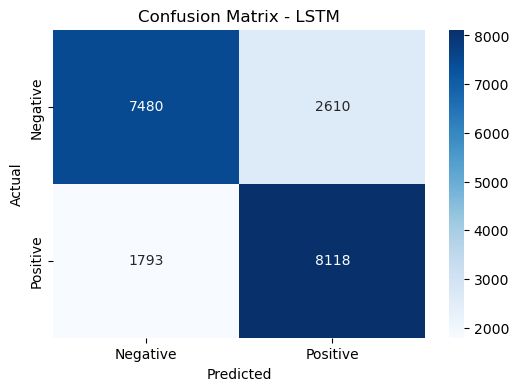

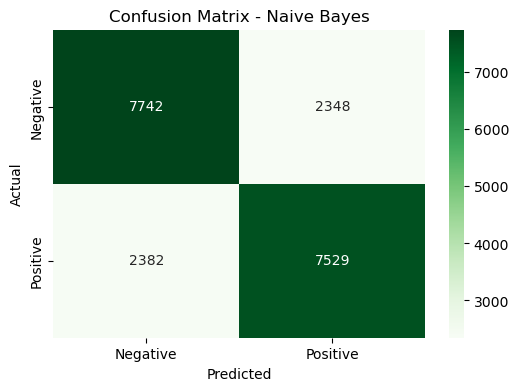

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Confusion matrix for LSTM predictions
lstm_cm = confusion_matrix(y_test, y_pred_lstm)  # Generate the confusion matrix for LSTM

# Create a heatmap for the LSTM confusion matrix
plt.figure(figsize=(6,4))  # Set the figure size for better visualization
sns.heatmap(lstm_cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative', 'Positive'], 
            yticklabels=['Negative', 'Positive'])  # Use blue color shades and display labels
plt.title("Confusion Matrix - LSTM")  # Title for the LSTM confusion matrix plot
plt.ylabel('Actual')  # Label for the y-axis showing actual class labels
plt.xlabel('Predicted')  # Label for the x-axis showing predicted class labels
plt.show()  # Display the plot

# Confusion matrix for Naive Bayes predictions
nb_cm = confusion_matrix(y_test, y_pred)  # Generate the confusion matrix for Naive Bayes

# Create a heatmap for the Naive Bayes confusion matrix
plt.figure(figsize=(6,4))  # Set the figure size for consistency
sns.heatmap(nb_cm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=['Negative', 'Positive'], 
            yticklabels=['Negative', 'Positive'])  # Use green color shades and display labels
plt.title("Confusion Matrix - Naive Bayes")  # Title for the Naive Bayes confusion matrix plot
plt.ylabel('Actual')  # Label for the y-axis showing actual class labels
plt.xlabel('Predicted')  # Label for the x-axis showing predicted class labels
plt.show()  # Display the plot

## 5. ROC Curve Visualization
Shows the performance of models in terms of TPR and FPR

626/626 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step


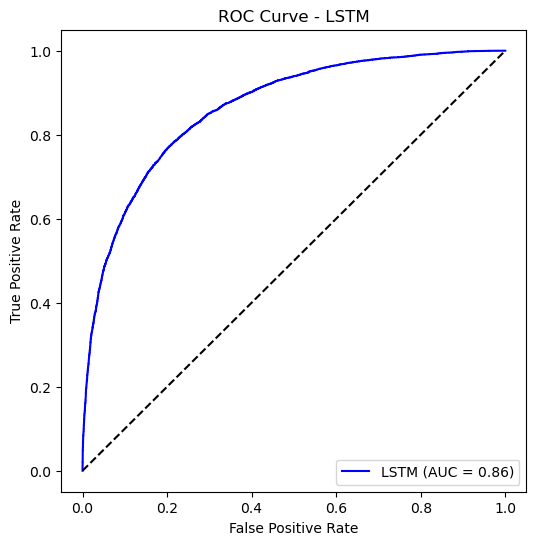

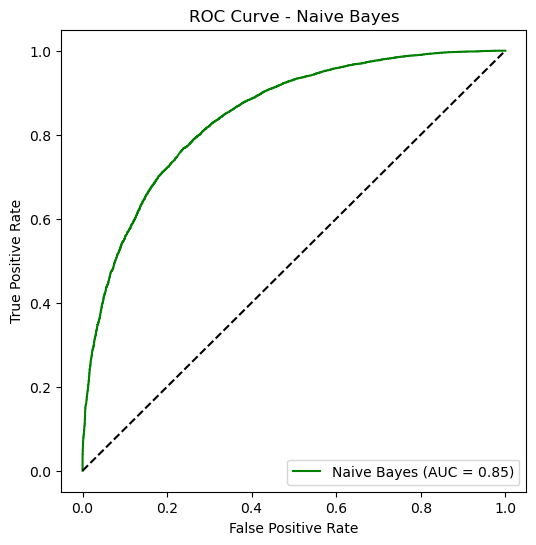

In [50]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# ROC Curve for LSTM model
# Generate the false positive rate (fpr), true positive rate (tpr), and thresholds for the LSTM model
lstm_fpr, lstm_tpr, _ = roc_curve(y_test, model.predict(X_test_padded))  

# Calculate the AUC for LSTM
lstm_auc = auc(lstm_fpr, lstm_tpr)

# Plotting the ROC Curve for LSTM
plt.figure(figsize=(6,6))  # Set figure size to make the graph clear and square
plt.plot(lstm_fpr, lstm_tpr, label=f'LSTM (AUC = {lstm_auc:.2f})', color='blue')  # Plot fpr vs tpr for LSTM
plt.plot([0,1], [0,1], 'k--')  # Plot a diagonal reference line (random classifier line)
plt.xlabel('False Positive Rate')  # Label x-axis as False Positive Rate
plt.ylabel('True Positive Rate')  # Label y-axis as True Positive Rate
plt.title('ROC Curve - LSTM')  # Add a title to the plot
plt.legend(loc='lower right')  # Display legend at the lower-right position
plt.show()  # Display the plot

# ROC Curve for Naive Bayes model
# Generate the false positive rate (fpr), true positive rate (tpr), and thresholds for the Naive Bayes model
nb_fpr, nb_tpr, _ = roc_curve(y_test, nb.predict_proba(X_test_tfidf)[:, 1])  

# Calculate the AUC for Naive Bayes
nb_auc = auc(nb_fpr, nb_tpr)

# Plotting the ROC Curve for Naive Bayes
plt.figure(figsize=(6,6))  # Set figure size to make the graph clear and square
plt.plot(nb_fpr, nb_tpr, label=f'Naive Bayes (AUC = {nb_auc:.2f})', color='green')  # Plot fpr vs tpr for Naive Bayes
plt.plot([0,1], [0,1], 'k--')  # Plot a diagonal reference line (random classifier line)
plt.xlabel('False Positive Rate')  # Label x-axis as False Positive Rate
plt.ylabel('True Positive Rate')  # Label y-axis as True Positive Rate
plt.title('ROC Curve - Naive Bayes')  # Add a title to the plot
plt.legend(loc='lower right')  # Display legend at the lower-right position
plt.show()  # Display the plot

## 6. Accuracy and Loss Plot (for LSTM)
Displays the learning progress of LSTM

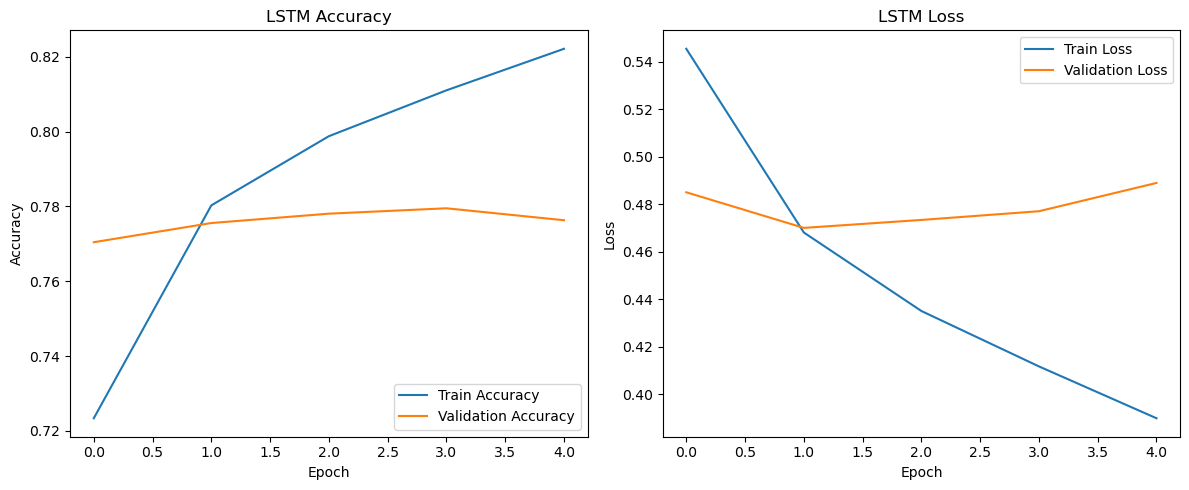

In [51]:
import matplotlib.pyplot as plt

# Set the figure size to make the plots visually appealing and easy to read
plt.figure(figsize=(12,5))

# Plotting training and validation accuracy
plt.subplot(1, 2, 1)  # Create a 1x2 grid of subplots, and this is the first subplot (left side)
plt.plot(history.history['accuracy'], label='Train Accuracy')  # Plot the accuracy values for the training set
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')  # Plot the accuracy values for the validation set
plt.title('LSTM Accuracy')  # Set the title of the accuracy plot
plt.ylabel('Accuracy')  # Label y-axis as Accuracy
plt.xlabel('Epoch')  # Label x-axis as Epoch (number of passes through the training data)
plt.legend(loc='lower right')  # Add a legend for distinguishing training vs validation lines, placed in the lower-right corner

# Plotting training and validation loss
plt.subplot(1, 2, 2)  # This is the second subplot (right side)
plt.plot(history.history['loss'], label='Train Loss')  # Plot the loss values for the training set
plt.plot(history.history['val_loss'], label='Validation Loss')  # Plot the loss values for the validation set
plt.title('LSTM Loss')  # Set the title of the loss plot
plt.ylabel('Loss')  # Label y-axis as Loss (binary cross-entropy loss)
plt.xlabel('Epoch')  # Label x-axis as Epoch (number of passes through the training data)
plt.legend(loc='upper right')  # Add a legend for distinguishing training vs validation lines, placed in the upper-right corner

# Adjust layout so the subplots don't overlap
plt.tight_layout()

# Display the combined plots
plt.show()

## 7. Bar Chart for Metrics Comparison
Helps in quick comparison between LSTM and Naive Bayes across multiple evaluation metrics

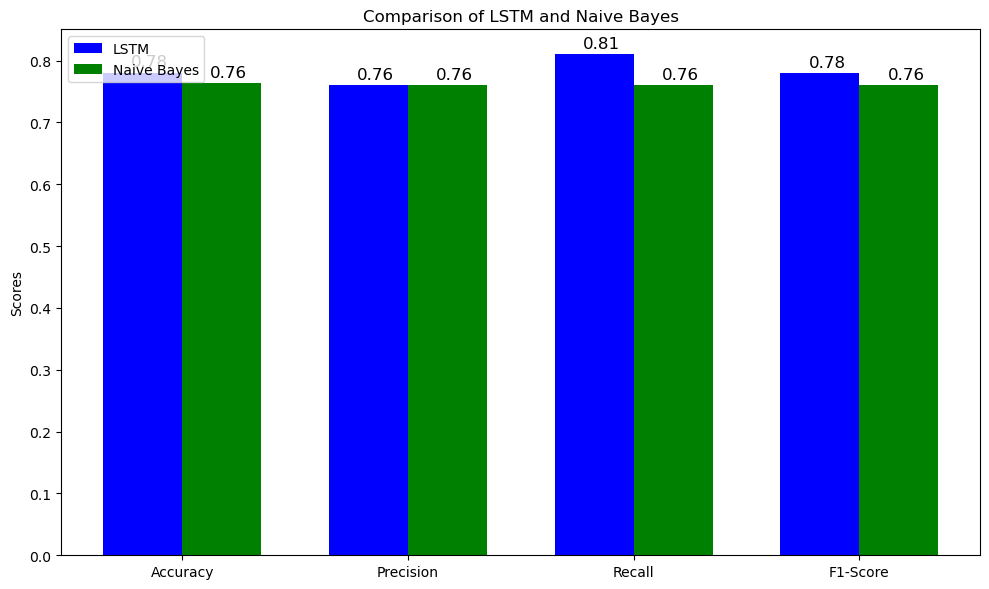

In [55]:
import matplotlib.pyplot as plt
import numpy as np

# Performance metrics for LSTM and Naive Bayes models
# Each list contains values for [Accuracy, Precision, Recall, F1-Score]
lstm_metrics = [0.7806, 0.76, 0.81, 0.78]  # Values for LSTM model
nb_metrics = [0.7635, 0.76, 0.76, 0.76]  # Values for Naive Bayes model

# Labels corresponding to the four metrics
labels = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

# Create an array representing the index positions for the four metric labels
x = np.arange(len(labels))

# Width of the bars in the bar chart
width = 0.35

# Set the size of the overall figure
plt.figure(figsize=(10, 6))

# Create the bars for LSTM metrics (positioned slightly left with respect to the metric labels)
bar1 = plt.bar(x - width/2, lstm_metrics, width, label='LSTM', color='blue')

# Create the bars for Naive Bayes metrics (positioned slightly right with respect to the metric labels)
bar2 = plt.bar(x + width/2, nb_metrics, width, label='Naive Bayes', color='green')

# Add numeric values above each LSTM bar for readability
for bar in bar1:
    yval = bar.get_height()  # Get the height (value) of each bar
    plt.text(bar.get_x() + bar.get_width()/2 - 0.05, yval + 0.01, f'{yval:.2f}', fontsize=12)

# Add numeric values above each Naive Bayes bar for readability
for bar in bar2:
    yval = bar.get_height()  # Get the height (value) of each bar
    plt.text(bar.get_x() + bar.get_width()/2 - 0.05, yval + 0.01, f'{yval:.2f}', fontsize=12)

# Set the y-axis label to indicate the type of values being plotted
plt.ylabel('Scores')

# Set the title of the chart
plt.title('Comparison of LSTM and Naive Bayes')

# Set the labels for the x-axis (the metric names: Accuracy, Precision, etc.)
plt.xticks(x, labels)

# Add a legend to differentiate between LSTM and Naive Bayes bars
plt.legend()

# Adjust layout to avoid any overlap or cutoff of elements
plt.tight_layout()

# Display the bar chart
plt.show()

In [56]:
import os
notebook_path = os.path.abspath("Twitter_Sentiment_Analysis.ipynb")
print(notebook_path)

C:\Users\abhis\Twitter_Sentiment_Analysis.ipynb
